In [101]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set(font_scale=0.7)

In [102]:
start = '2023-07-17T21:51:12.507+01:00'
end = '2023-07-17T22:04:40.866+01:00'

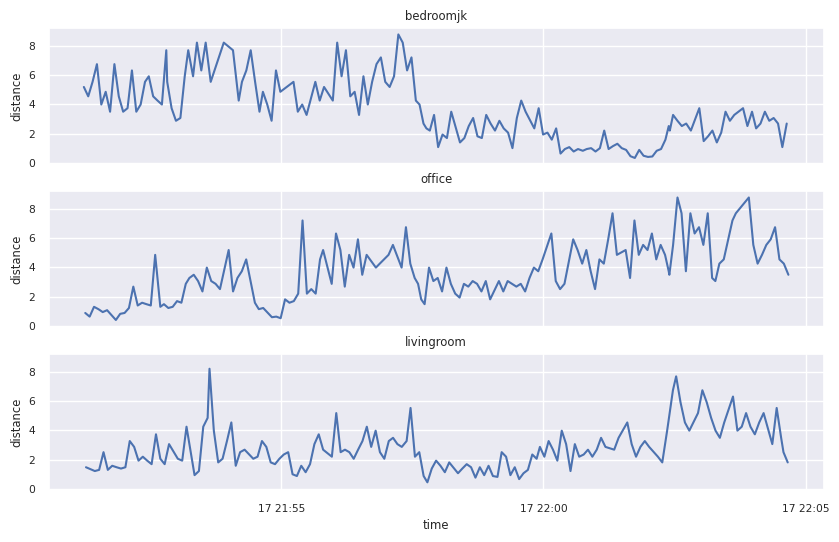

In [150]:
df = (
    pd.read_csv('data.csv', index_col=0, parse_dates=True)
    .rename(columns={'m.friendly_name_str': 'basestation', 'm.value': 'distance', 'state.state': 'room'})
    .replace({'basestation': {
        'MQTT iPhoneJD LivingRoom Raw': 'livingroom',
        'MQTT iPhoneJD Office Raw': 'office',
        'MQTT iPhoneJD BedroomJK Raw': 'bedroomjk'
    }})
    .dropna(subset=['basestation'])
    .loc[start:end]
)

fig, ax = plt.subplots(3, figsize=(10, 6), sharex=True, sharey=True)

for i, basestation in enumerate(df.basestation.unique()):
    sns.lineplot(df.loc[df.basestation == basestation, 'distance'], ax=ax[i]).set_title(basestation)
plt.show()

In [103]:
df = (
    pd.read_csv('data.csv')
    .drop(['state.state'], axis=1)
    .rename(columns={'m.friendly_name_str': 'room', 'm.value': 'distance'})
    .dropna(subset=['room'])
    .replace({'room': {
        'MQTT iPhoneJD LivingRoom Raw': 'livingroom',
        'MQTT iPhoneJD Office Raw': 'office',
        'MQTT iPhoneJD BedroomJK Raw': 'bedroomjk'
    }})
    .pivot(index='time', columns='room', values='distance')
    .fillna(method='ffill')
    .dropna()
    .loc[start:end]
)
X = df
print(df.shape)
df.head()

(455, 3)


room,bedroomjk,livingroom,office
time,,,
2023-07-17T21:51:14.278+01:00,5.18,1.39,0.67
2023-07-17T21:51:15.874+01:00,5.18,1.39,0.88
2023-07-17T21:51:16.718+01:00,5.18,1.48,0.88
2023-07-17T21:51:19.291+01:00,4.54,1.48,0.88
2023-07-17T21:51:20.910+01:00,4.54,1.48,0.63


In [167]:
df = (
    pd.read_csv('data.csv')
    .rename(columns={'m.friendly_name_str': 'basestation', 'm.value': 'distance', 'state.state': 'room'})
    .replace({'basestation': {
        'MQTT iPhoneJD LivingRoom Raw': 'livingroom',
        'MQTT iPhoneJD Office Raw': 'office',
        'MQTT iPhoneJD BedroomJK Raw': 'bedroomjk'
    }})
    .pivot(index=['time', 'room'], columns='basestation', values='distance')
    .reset_index('room')
    #.drop(['NaN'], axis=1)
    .fillna(method='ffill')
    .loc[start:end]
)
print(df.head())

X = df[['livingroom', 'office', 'bedroomjk']].values
y = df['room']

basestation                      room  NaN  bedroomjk  livingroom  office
time                                                                     
2023-07-17T21:51:12.507+01:00  Office  NaN       4.54        1.39    0.67
2023-07-17T21:51:14.278+01:00  Office  NaN       5.18        1.39    0.67
2023-07-17T21:51:15.874+01:00  Office  NaN       5.18        1.39    0.88
2023-07-17T21:51:16.718+01:00  Office  NaN       5.18        1.48    0.88
2023-07-17T21:51:19.291+01:00  Office  NaN       4.54        1.48    0.88


Text(0.5, 1.0, 'K-Means Clustering')

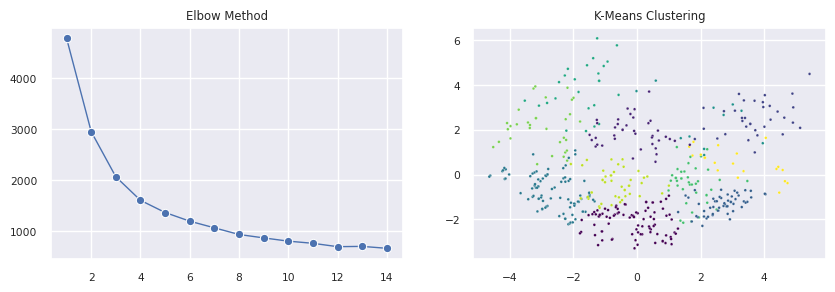

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

inertia = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

kmeans = KMeans(n_clusters=11, random_state=0, n_init='auto').fit(X)
pca = PCA(n_components=2).fit_transform(X)

sns.lineplot(x=range(1, 15), y=inertia, marker='o', color='b', linewidth=1, ax=ax[0]).set_title('Elbow Method')
sns.scatterplot(x=pca[:, 0], y=pca[:, 1], c=kmeans.labels_, s=4, cmap='viridis', ax=ax[1]).set_title('K-Means Clustering')

In [111]:
pd.crosstab(y, kmeans.labels_)

col_0,0,1,2,3,4,5,6,7,8,9,10
room,,,,,,,,,,,
BedroomCC,0,0,14,0,0,7,0,8,0,0,2
BedroomJK,8,0,0,43,0,0,0,10,0,0,7
BedroomS,0,1,18,0,0,1,0,11,0,0,4
DiningRoom,0,15,1,0,3,0,4,0,7,11,1
Hallway0,6,3,0,0,38,0,0,0,6,1,0
Hallway1,6,0,0,0,3,0,0,0,0,13,3
Hallway2,6,1,1,10,0,1,0,11,0,6,3
Kitchen,0,13,0,0,0,0,7,0,6,0,0
LivingRoom,57,0,0,1,1,0,0,0,0,9,0


In [109]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Scatter3d(
    x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers',
    marker=dict(size=3, color=kmeans.labels_, colorscale='Viridis', opacity=0.8)
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
import paho.mqtt.client as mqtt
import json

verbose = False

X_live = {
    'espresense/devices/jd_iphone/bedroomjk': 0.,
    'espresense/devices/jd_iphone/livingroom': 0.,
    'espresense/devices/jd_iphone/office': 0.,
}

room = {
    1: 'livingroom',
    2: 'bedroomcc',
    3: '',
    4: 'bedroomjk',
    5: 'playroom',
    6: 'bedrooms',
    7: 'office',
    8: '',
    9: 'hallway2',
    10: '',
    11: '',
}

def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    client.subscribe("espresense/devices/jd_iphone/bedroomjk")
    client.subscribe("espresense/devices/jd_iphone/office")
    client.subscribe("espresense/devices/jd_iphone/livingroom")

def on_message(client, userdata, msg):
    data = json.loads(msg.payload)
    if 'raw' in data:
        X_live[msg.topic] = data['raw']
        x = np.array(list(X_live.values())).reshape(1, -1)
        pred = kmeans.predict(x)
        if verbose > 1:
            print(f"Topic: {msg.topic} Raw Value: {data['raw']}")
            print(f"X_live: {X_live}")
            print(f"X: {x}")
            print(f"y: {pred}")
        elif verbose > 0:
            print(f"{x=}, {pred=} {room[pred[0]]}")
        else:
            print(pred)

client = mqtt.Client()
client.username_pw_set("mqtt-user", "vlmSDF543")
client.on_connect = on_connect
client.on_message = on_message
client.connect("192.168.50.134", 1883, 60)
client.loop_forever()

Connected with result code 0
[4]
[4]
[4]
[4]


KeyboardInterrupt: 

In [162]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_poly)

In [164]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0)

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr.score(X_test, y_test)

0.6386554621848739

In [166]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = lr.predict(X_test)
confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   BedroomCC       1.00      0.55      0.71        11
   BedroomJK       0.62      0.83      0.71        18
    BedroomS       0.70      1.00      0.82         7
  DiningRoom       0.50      0.36      0.42        11
    Hallway0       0.40      0.33      0.36        12
    Hallway1       0.00      0.00      0.00         3
    Hallway2       0.30      0.21      0.25        14
     Kitchen       0.75      0.60      0.67         5
  LivingRoom       0.86      0.95      0.90        19
      Office       0.60      0.90      0.72        10
    Playroom       0.64      0.78      0.70         9

    accuracy                           0.64       119
   macro avg       0.58      0.59      0.57       119
weighted avg       0.62      0.64      0.61       119



/home/justin/git/espresense-ml/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/justin/git/espresense-ml/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/justin/git/espresense-ml/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [117]:
import paho.mqtt.client as mqtt
import json

verbose = False

X_live = {
    'espresense/devices/jd_iphone/bedroomjk': 0.,
    'espresense/devices/jd_iphone/livingroom': 0.,
    'espresense/devices/jd_iphone/office': 0.,
}

def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    client.subscribe("espresense/devices/jd_iphone/bedroomjk")
    client.subscribe("espresense/devices/jd_iphone/office")
    client.subscribe("espresense/devices/jd_iphone/livingroom")

def on_message(client, userdata, msg):
    data = json.loads(msg.payload)
    if 'raw' in data:
        X_live[msg.topic] = data['raw']
        x = np.array(list(X_live.values())).reshape(1, -1)
        print(lr.predict(x))

client = mqtt.Client()
client.username_pw_set("mqtt-user", "vlmSDF543")
client.on_connect = on_connect
client.on_message = on_message
client.connect("192.168.50.134", 1883, 60)
client.loop_forever()

Connected with result code 0
['Office']
['LivingRoom']
['Hallway0']
['Hallway0']
['Hallway0']
['Hallway0']
['Hallway0']
['Hallway0']
['Hallway0']
['Hallway0']
['Hallway0']


KeyboardInterrupt: 